In [2]:
import requests
import json
import os
import re
import datetime
import time
import string
import pandas as pd
import urllib
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import yfinance as yf
import numpy as np
import nltk
from time import sleep
from bs4 import BeautifulSoup
from requests import get
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from transformers import pipeline
from bs4 import BeautifulSoup as bs
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

C:\Users\endyj\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Google Scraping

In [24]:
def get_useragent():
    return random.choice(_useragent_list)

_useragent_list = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36 Edg/111.0.1661.62',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/111.0'
]

request_timeout = 10
headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
        'Cache-Control': 'private, max-age=0',
}
cookies = {
    'AEC': 'Ae3NU9NQU2mqLz-7wrJXwMEAaaRFg80VzW_-fAc7ByMmTS5AuM4AeDHSwA',
    'SOCS': 'CAISHwgCEhJnd3NfMjAyNDAzMjctMF9SQzEaBXpoLVRXIAEaBgiArJ2wBg'
}
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
#TODAY = datetime.date.today()
TODAY = '2024-03-30'
MAX_WORD = 1000
words = set(nltk.corpus.words.words())

#search variables
from_date = '1/1/2024'
to_date = '30/3/2024'
total_news = 30
sleep_interval = 10
stock_name = 'MSFT'

#NLP variables
model_id = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

In [4]:
"""googlesearch is a Python library for searching Google, easily."""
def get_headers(): 
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
        'Cache-Control': 'private, max-age=0',
        'Set-Cookie': 'CONSENT=PENDING+944'
    }

    return headers

def _req(term, results, lang, start, proxies, timeout, from_date, to_date):
    resp = get(
        url="https://www.google.com/search",
        headers=headers,
        params={
            "q": term,
            "num": results,  # Prevents multiple requests
            "hl": lang,
            "start": start,
            "lr": "lang_en",
            "tbm": 'nws',
            "tbs": f'sbd:1,cdr:1,cd_min:{from_date},cd_max:{to_date}'
            #"tbs": "qdr:d"
            #"tbs": f"sbd:1,lr:lang_en,cdr:1,cd_min:1/1/{from_year},cd_max:{to_year}"
        },
        proxies=proxies,
        timeout=timeout,
        cookies=cookies
    )
    resp.raise_for_status()
    return resp

def search(term, num_results=10, lang="en", proxy=None, advanced=False, sleep_interval=10, timeout=5, from_date='1/1/2020', to_date='1/1/2020'):
    """Search the Google search engine"""

    escaped_term = urllib.parse.quote_plus(term) # make 'site:xxx.xxx.xxx ' works.

    # Proxy
    proxies = None
    if proxy:
        if proxy.startswith("https"):
            proxies = {"https": proxy}
        else:
            proxies = {"http": proxy}

    # Fetch
    start = 0
    res = []

    resp = _req(escaped_term, num_results - start,
                lang, start, proxies, timeout, from_date, to_date)
    # Parse
    soup = BeautifulSoup(resp.text, "html.parser")
    result_block = soup.find_all("div", attrs={"class": "SoaBEf"})
    # print(resp.text)
    for result in soup.find_all("div", attrs={ "class": "Gx5Zad fP1Qef xpd EtOod pkphOe" }):
        # Find url, title, description
        url = result.find("a", href=True)
        title = result.find("div", attrs={"class": "BNeawe vvjwJb AP7Wnd"})
        date = from_date
        obj = {}
        obj["title"] = None
        obj["date"] = None
        obj["url"] = None
        start += 1

        if title:
            obj["title"] = title.text
        if date:
            obj["date"] = from_date
        if url:
            link = url["href"]
            link = link[link.index('url=') + 4:]
            link = link[: link.index('&ved=')]
            obj["url"] = link
            
            res.append(obj)

    sleep(sleep_interval)
    return res

In [5]:
def get_google_news_urls(q, total, from_date, to_date, sleep_interval=10):
    urls = []
    urls = search(q, num_results=total, from_date=from_date, to_date=to_date, sleep_interval=sleep_interval)
    return urls

In [6]:
def save_news_urls(q, total, from_date, to_date, temp_save=False):
    dir_name = str(TODAY)
    if dir_name not in os.listdir():
        cwd = os.getcwd()
        os.mkdir(f'{cwd}/{dir_name}')
        
    urls = get_google_news_urls(q, total, from_date, to_date, sleep_interval = sleep_interval)
    # temp
    if temp_save:
        # replace date format to file savable characters
        filename = f'{query}_{from_date.replace("/", "_")}.json'
        f = open(f'./{TODAY}/{filename}', 'w')
        f.write(json.dumps(json_object, indent = 4))
        f.close()
    return urls

In [7]:
def get_news_data(url):
    text = ""
    try:
        article = requests.get(
            url,
            headers=headers,
            timeout=request_timeout
        )
        status_code = article.status_code
        if status_code >= 400:
            f = open(f'./{TODAY}/ERROR_LOG.txt', 'a')
            f.write(f'[{time.asctime(time.localtime())}] Code {status_code}: {url}\n')
            f.close()
            return None
        soup = bs(article.content, "html.parser")
        article_body = soup.find("body")
        if article_body == None:
            return ""
        paragraphs = article_body.find_all("p")
        #sleep(1)
        if paragraphs is not None:
            for p in paragraphs:
                text += re.sub(html_pattern, '', p.text).strip() + ' '  
        return text
    except requests.exceptions.RequestException as e:
        msg = e

In [8]:
def save_dataset(q, json_object, date):
    total_count = 0
    for data in json_object:  
        try:
            data['text'] = get_news_data(data['url'])
            if data is None:
                continue
            if q not in os.listdir(f'./{TODAY}'):
                cwd = os.getcwd()
                os.mkdir(f'{cwd}/{TODAY}/{q}')
            total_count += 1
            file_error_symbols = []
            filename = f'{total_count}_{date.replace("/", "_")}'
            f = open(f'./{TODAY}/{q}//{filename}.json', "w")
            f.write(json.dumps(data, indent = 4))
            f.close()
        except requests.exceptions.RequestException as e:
            print(e)
    print(f'Saved {total_count} news data in {date}')
    #print(os.system("npx prettier -w ./dataset/*.json"))

In [9]:
def get_urls_from_file(filename):
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    return data

In [10]:
def get_keywords_from_file(filename):
    keywords = []
    f = open(filename, "r")
    for keyword in f:
        keywords.append(keyword)
    f.close()
    return list(map(lambda keyword: keyword.strip(), keywords))

In [11]:
#run all functions to save news data
def scrap_news_data(total, from_date, to_date, keywords_filename="keywords.txt"):
    #count used time
    start = time.time()
    #step 1 - load keywords file
    keywords = get_keywords_from_file(keywords_filename)
    for query in keywords:
        print(f'Scrapping {query} ...')
        #step 2 - save urls to json file
        save_news_urls(query, total, from_date, to_date)
        #step 3 - get urls object from previous saved json file
        urls = get_urls_from_file(f'./{TODAY}/{query}.json')
        #step 4 - web scrapping news data from specific year of urls & save into directory seperately
        save_dataset(query, urls, from_date)
        #parallel_save_dataset(query, urls, date)
        #save_dataset(query, urls)
        
    end = time.time()
    print('[DONE] {:.2f} seconds used'.format(end - start))

In [12]:
def json_to_csv(q, json_obj, index):
    text = None
    title = None
    date = None
    url = json_obj['url']
    if 'date' in json_obj.keys():
        date = json_obj['date']
    if json_obj['text'] is not None:
        text = re.sub(r'[,.\'"|]', '', json_obj['text'])
    if 'title' in json_obj.keys() and json_obj['title'] != None:
        title = re.sub(r'[,.\'"|]', '', json_obj['title'])
    if text != '' and text != None:
        text = ' '.join(text.encode('utf-8').decode().split())
    if title != '' and title != None:
        title = ' '.join(title.split()).strip() 
    f = open(f'./{TODAY}/{q}.csv', 'a', encoding='utf-8')
    f.write(f'{index},\"{title}\",\"{date}\",\"{url}\",\"{text}\"\n')
    f.close()

In [13]:
def to_date_time_format(date):
    date = date.split('/')
    date = list(map(lambda x: int(x), date))
    return datetime.datetime(date[2], date[1], date[0])

def to_google_param_format(date):
    return f'{date.month}/{date.day}/{date.year}'

def save_json_object(filename, json_object):
    f = open(f'./{TODAY}/{filename}', 'w')
    f.write(json.dumps(json_object, indent = 4))
    f.close()
    
def get_date_range_list(from_date, to_date):
    from_date_time = to_date_time_format(from_date)
    to_date_time = to_date_time_format(to_date)
    day_difference = (to_date_time - from_date_time).days
    datetime_list = [from_date_time + datetime.timedelta(days=x) for x in range(day_difference + 1)]
    date_range_list = list(map(lambda x: to_google_param_format(x), datetime_list))
    return date_range_list
    
def parallel_save_dataset(query, from_date, to_date):
    # count used time
    start = time.time()
    # JSON object
    json_object = dict()
    # get from date & to date difference days
    date_range_list = get_date_range_list(from_date, to_date)
    # iterate through date range list
    for date in date_range_list:
        urls = save_news_urls(query, total_news, date, date)
        json_object[date] = urls

    filename = f'{query}.json'
    # temporary save of the scrapped urls
    save_json_object(filename, json_object)
    # parallel computing to save news data
    Parallel(n_jobs = -1)(delayed(save_dataset)(query, json_object[date], date) for date in json_object)
    #for date in json_object:
    #    save_dataset(query, json_object[date], date)
    # convert all json file in single csv file
    all_json_to_csv(stock_name)
    print(f'{filename}: [DONE]')

In [14]:
def all_json_to_csv(stock_name):
    cols = "title,date,url,text\n"
    keywords = get_keywords_from_file('keywords.txt')
    for keyword in keywords:
        f = open(f'./{TODAY}/{stock_name}.csv', 'w')
        f.write(cols)
        f.close()
        if stock_name not in os.listdir(f'./{TODAY}'):
            os.mkdir(f'./{TODAY}/{stock_name}')
        for index, filename in enumerate(os.listdir(f'./{TODAY}/{stock_name}')):
            if '.json' not in filename:
                continue
            json_file = open(f'./{TODAY}/{stock_name}/{filename}', 'r')
            json_obj = json.load(json_file)
            json_file.close()
            json_to_csv(stock_name, json_obj, index)
    print('Done')

In [15]:
def get_preprocessed_text(text):
    text = str(text)
    stop_words = set(stopwords.words("english"))
    special_characters = "!@#$%^&*()-+?_=,<>\""
    lemmatizer = WordNetLemmatizer()
    tokenized_words = word_tokenize(text.lower())
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenized_words]
    lemmatized_words = [word for word in lemmatized_words if word in words]
    preprocessed_words = [word for word in lemmatized_words if word not in stop_words]
    preprocessed_words = [word for word in lemmatized_words if word not in special_characters]
    preprocessed_text = " ".join(preprocessed_words)
    return preprocessed_text

In [16]:
def get_weighted_sentiment_score(stock_name, news_df):
    sentiment_obj = dict()
    sentiment_score_df = []
    news_df_length = len(news_df)
    start_time = time.time()
    sentiment_pipe = pipeline("sentiment-analysis", model=model_id, device=0, batch_size=1)
    
    for i in range(news_df_length):
        data = news_df.iloc[i]
        date = data['date']
        title = data['title']
        text = data['text']
        preprocessed_text = get_preprocessed_text(text)
        #preprocessed_text = text
        # check if news paragraph is too large for sentiment analysis
        if len(preprocessed_text.split(' ')) > MAX_WORD:
            #print(f'{title} Skiped')
            continue
        #print(data['url'])
        sentiment_result = sentiment_pipe(preprocessed_text)[0]
        score = sentiment_result['score']
        label = sentiment_result['label']
        #print(f'{date}: [{label}] {score}')
        
        if date not in sentiment_obj.keys():
            sentiment_obj[date] = dict()
            sentiment_obj[date]['score'] = 0
            sentiment_obj[date]['count'] = 0
        if label != 'neutral': 
            if label == 'positive':
                sentiment_obj[date]['score'] += score
            else:
                sentiment_obj[date]['score'] -= score
            sentiment_obj[date]['count'] += 1
    
    for date in sentiment_obj:
        date_list = list(map(lambda x: int(x), date.split('/')))
        datetime_obj = datetime.datetime(date_list[2], date_list[0], date_list[1])
        score = sentiment_obj[date]['score']
        count = sentiment_obj[date]['count']
        if count > 0:
            item = [datetime_obj,  score / count, count]
            sentiment_score_df.append(item)
        
    sentiment_score_df = sorted(sentiment_score_df, key=lambda x: x[0])
    sentiment_score_df = list(map(lambda x: [str(x[0].date()), x[1],  x[2]], sentiment_score_df))
    sentiment_score_df = pd.DataFrame(sentiment_score_df, columns =['Date', 'Score', 'Count'], dtype = float) 
    # temporary save
    end_time = time.time()
    print(f'Sentiment Analysis time used: {end_time - start_time}s')
    sentiment_score_df.to_csv(f'./{TODAY}/{stock_name}_sentiment_tmp.csv', index=False)
    
    return sentiment_score_df

In [17]:
def get_real_predict_label_list(stock_df, sentiment_df):
    stock_available_dates = stock_df['Date'].values
    date_length = len(stock_available_dates)
    stock_val_list = stock_df['Adj Close'].values
    sentiment_date_list = sentiment_df['Date'].values
    sentiment_score_list = []
    
    real_label_list = []
    predict_label_list = []
    
    for i in range(len(sentiment_df)):
        if sentiment_df.loc[i, 'Date'] in stock_available_dates:
            sentiment_score_list.append(sentiment_df.loc[i, 'Score'])
    
    sentiment_score_list = sentiment_df['Score'].values
    sentiment_date_list = sentiment_df['Date'].values
    
    for i in range(1, date_length):
        real_diff = stock_val_list[i] - stock_val_list[i-1]
        sentiment_diff = sentiment_score_list[i] - sentiment_score_list[i-1]
        
        if real_diff > 0:
            label = 'up'
        else:
            label = 'drop'
            
        real_label_list.append(label)
        
        if sentiment_diff > 0:
            label = 'up'
        else:
            label = 'drop'
            
        predict_label_list.append(label)
    
    return { 'real': real_label_list, 'predict': predict_label_list }

In [18]:
def get_movement_accuracy(stock_df, sentiment_df):
    # get real movement label list and predicted movement label list
    label_obj = get_real_predict_label_list(stock_df, sentiment_df)
    # compare the movement accuracy
    real_label_list = label_obj['real']
    predict_label_list = label_obj['predict']
    label_list_length = len(real_label_list) 
    total = 0
    for i in range(label_list_length):
        if real_label_list[i] == predict_label_list[i]:
            total += 1
    accuracy = total / label_list_length
    return accuracy

In [26]:
def plot_graph(stock_name, index_arr, score_arr):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(index_arr, score_arr)
    ax.set_title(f'{stock_name} Sentiment Score')
    ax.set_xlabel(f'Date')
    ax.set_ylabel(f'Score')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

In [20]:
def test_sentiment_analysis(stock_name, from_date, to_date):
    # step 1 - save stock's related news data
    parallel_save_dataset(stock_name, from_date, to_date)
    
    # step 2 - load news dataframe and remove null/empty row
    news_df = pd.read_csv(f"./{TODAY}/{stock_name}.csv")
    news_df = news_df.mask(news_df.eq('None')).dropna(subset=['text'])
    
    # step 3 - load stocks historical data for directional testing
    stock_df = yf.download(stock_name, start='2024-01-01', end='2024-03-30')
    stock_df = stock_df.reset_index()
    stock_df['Date'] = stock_df['Date'].apply(lambda x: str(x.date()))
    
    # step 4 - get weighted sentiment score from news data and seperate by each day
    sentiment_df = get_weighted_sentiment_score(stock_name, news_df)
    
    # step 5 - compare movement accuracy between real data and sentiment analysis 
    accuracy = get_movement_accuracy(stock_df, sentiment_df)
    print(f'{stock_name} Sentiment Analysis Accuracy: {accuracy}')
    evaluation(stock_df, sentiment_df)

In [21]:
def evaluation(stock_df, sentiment_df):
    #get real movement label list and predicted movement label list
    label_obj = get_real_predict_label_list(stock_df, sentiment_df)
    # compare the movement accuracy
    real_label_list = label_obj['real']
    predict_label_list = label_obj['predict']
    
    accuracy = accuracy_score(real_label_list, predict_label_list)
    matrix = confusion_matrix(real_label_list, predict_label_list)
    report = classification_report(real_label_list, predict_label_list)
    print(f'Accuracy score: {accuracy}')
    print(f'Confusion Matrix: \n{matrix}')
    print(report)

def get_stock_df(stock_name):
    stock_df = yf.download(stock_name, start='2024-01-01', end='2024-03-30')
    stock_df = stock_df.reset_index()
    stock_df['Date'] = stock_df['Date'].apply(lambda x: str(x.date()))
    return stock_df

def get_sentiment_df(stock_name):
    df = pd.read_csv(f'./{TODAY}/{stock_name}_sentiment.csv')
    return df

In [48]:
#MSFT Sentiment Analysis Accuracy: 0.5166666666666667
#AAPL Sentiment Analysis Accuracy: 0.5833333333333334
#TSLA Sentiment Analysis Accuracy: 0.6
#NVDA Sentiment Analysis Accuracy: 0.4
#AMD Sentiment Analysis Accuracy: 0.5333333333333333
#GOOG Sentiment Analysis Accuracy: 0.5166666666666667

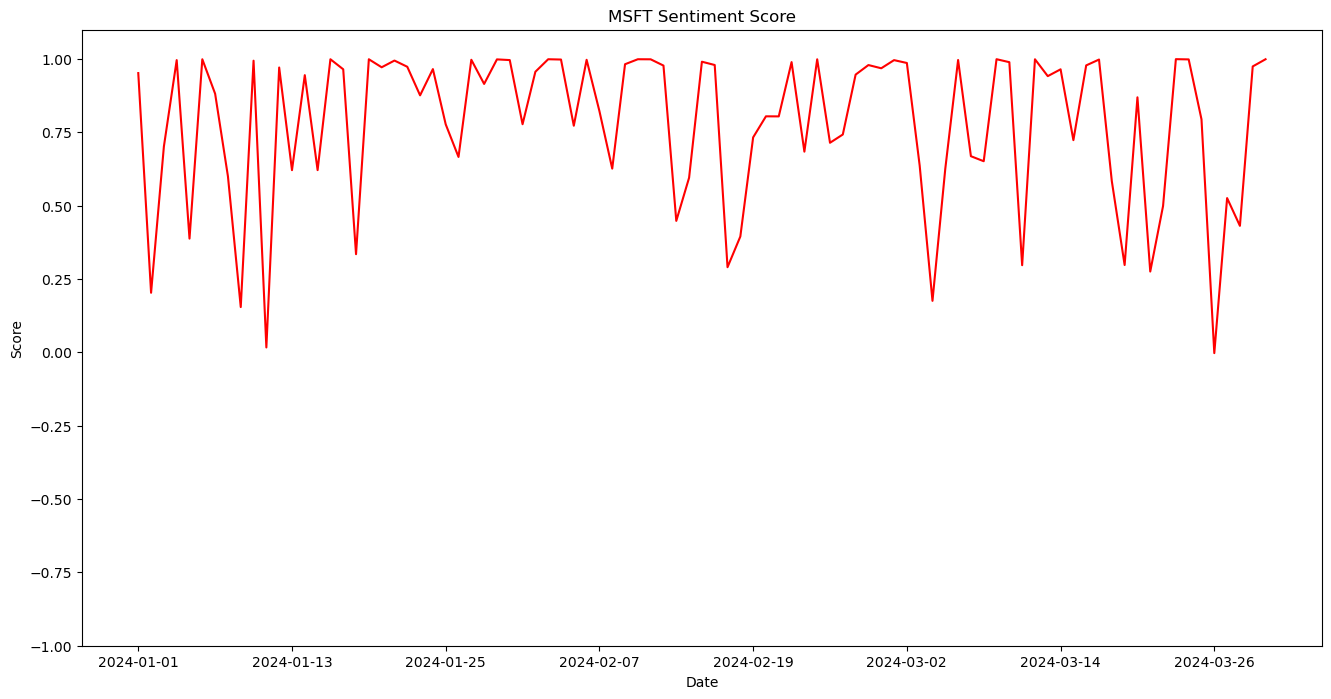

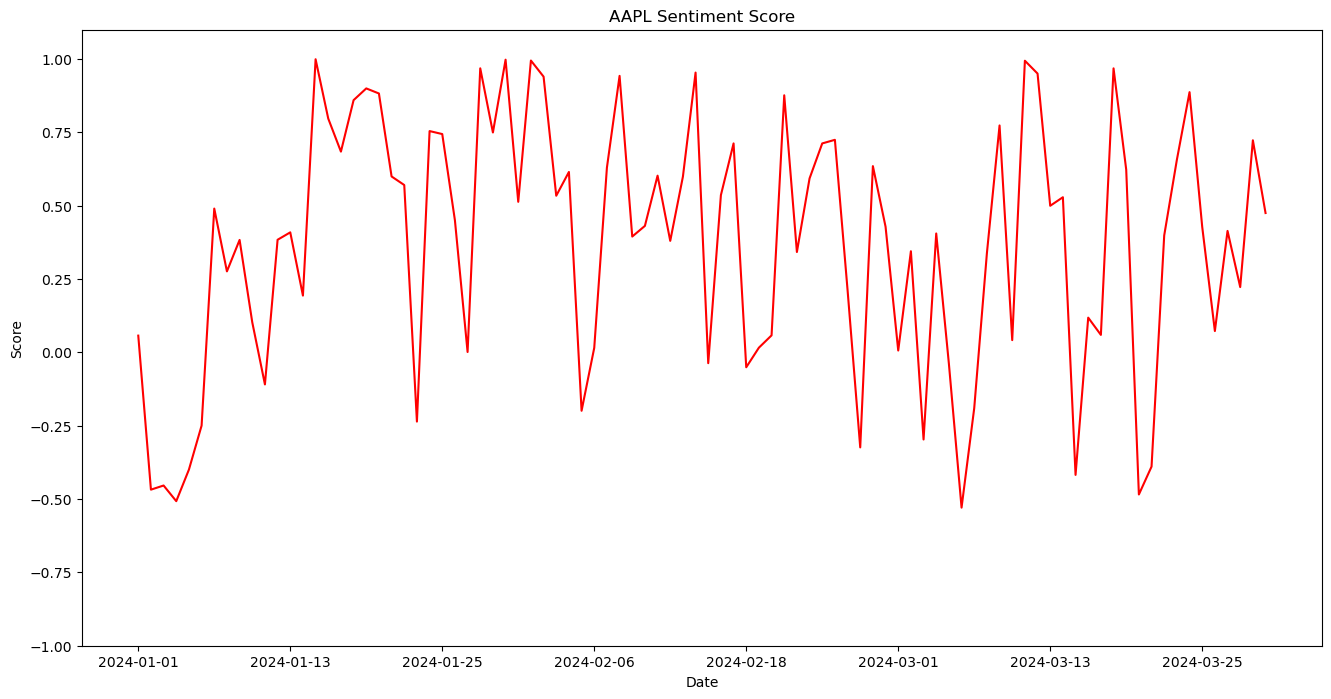

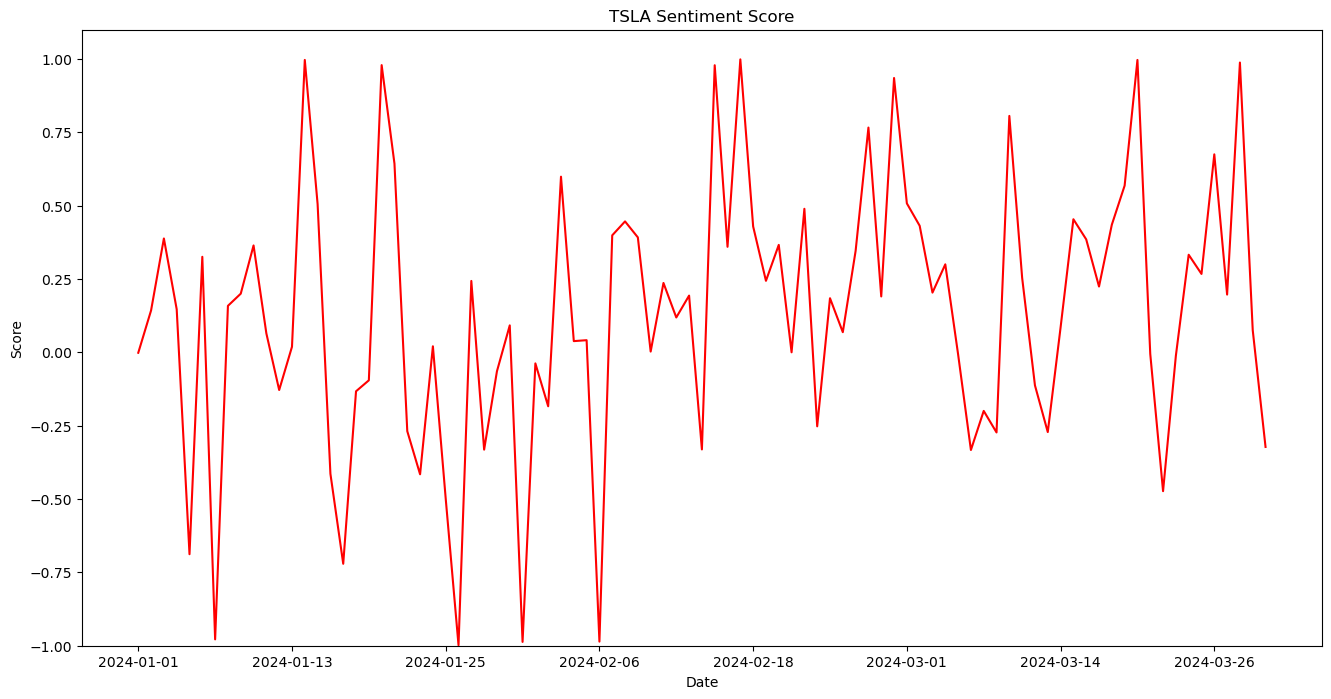

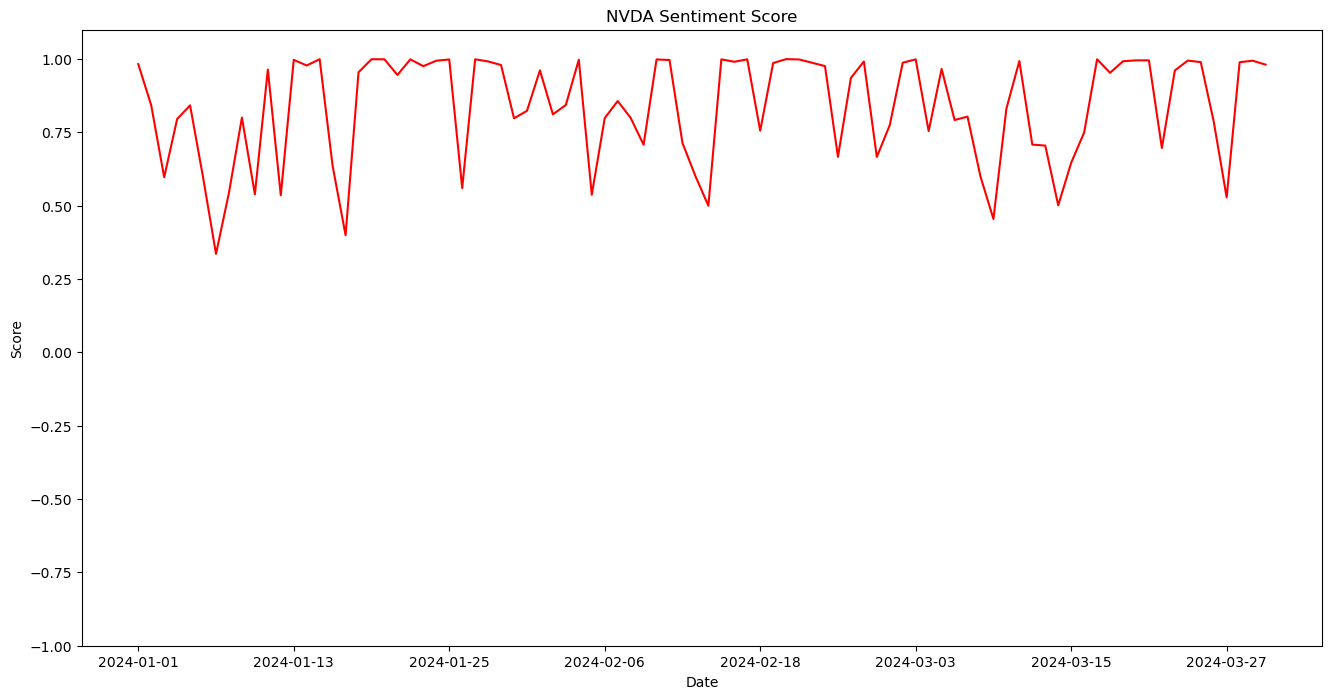

In [80]:
stock_list = ['MSFT', 'AAPL', 'TSLA', 'NVDA']
for stock_name in stock_list:
    fig, ax = plt.subplots(figsize=(16, 8))
    df = get_sentiment_df(stock_name)
    index = df['Date'].values
    score = df['Score'].values
    ax.plot(index, score, label=stock_name, color='red')
    ax.set_title(f'{stock_name} Sentiment Score')
    ax.set_xlabel(f'Date')
    ax.set_ylabel(f'Score')
    ax.set_ylim(ymin=-1, ymax=1.1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=12))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
    fig.savefig(f'./{stock_name}.png', dpi=600, bbox_inches="tight")

In [62]:
NVDA_df['Score'].values

array([0.98277423, 0.84224065, 0.59718519, 0.79551563, 0.84214073,
       0.59706496, 0.33588219, 0.54436672, 0.80030949, 0.53908183,
       0.96415209, 0.53564435, 0.99725104, 0.97800648, 0.99945444,
       0.63557126, 0.39952204, 0.95476483, 0.99939377, 0.9991978 ,
       0.94573465, 0.99896002, 0.97575321, 0.99435212, 0.9986161 ,
       0.56021119, 0.99903993, 0.9919125 , 0.9796007 , 0.79791684,
       0.82356506, 0.96134115, 0.8115378 , 0.8435394 , 0.99788461,
       0.53753361, 0.79854669, 0.85685777, 0.79964248, 0.70781503,
       0.99870514, 0.99671049, 0.71398549, 0.60117993, 0.49996725,
       0.99901711, 0.99075855, 0.99896852, 0.75565383, 0.98649847,
       0.99970031, 0.99864396, 0.98746656, 0.97594111, 0.66672721,
       0.93568012, 0.99164017, 0.66625644, 0.77523518, 0.98744779,
       0.99901744, 0.75448531, 0.96624574, 0.79220361, 0.80371971,
       0.59945514, 0.45470052, 0.8308009 , 0.99309165, 0.70829365,
       0.70496737, 0.50135727, 0.64647243, 0.74951329, 0.99913